<a href="https://colab.research.google.com/github/VitalyGladyshev/med_work/blob/main/Med_Stat_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прикладная статистика в медицине

## ДЗ 6 Гладышев В.В.

## Регрессионные модели

### Загрузка и подключение библиотек

In [25]:
knitr::opts_chunk$set(echo = TRUE)
library(ggplot2)
library(dplyr)
library(tidyverse)

In [2]:
install.packages('car')
library(car) #подключение библиотеки

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode




### Загрузка и подготовка данных

In [28]:
data_metadata <- read.csv('/content/metadata.tsv', header = TRUE, sep = '\t')
head(data_metadata)

,Vialnumber,Patientnumber,Sucrose,Name,Group,Date,Age,Plasmavolume,Ht,Wt,⋯,rlatmax,rantmax,rposmax,llatmax,lantmax,lposmax,carotidIMTmean,Plaque,Statins,comorbidities
,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
1,1,50,0,"Begaye, Decarlo",0,2023-01-14,63,6.5,163,84.0,⋯,0.65,0.80,0.80,0.81,0.78,0.80,0.6425000,1,1,NA
2,2,51,0,"Sweetwater, Kristen",0,2022-10-09,47,5.5,179,111.0,⋯,1.03,0.92,1.03,1.03,1.03,1.09,0.8400000,1,0,NA
3,3,52,0,"Figurelli, Samuel",1,2023-10-24,57,7.0,164,80.0,⋯,1.00,0.90,0.95,0.85,0.90,0.90,0.8500000,3,1,Type 2 diabetes mellitus; MI - 2016
4,4,53,0,"Pamphille, Mehgan",1,2023-07-02,72,5.0,160,58.8,⋯,0.91,0.97,0.98,0.86,0.74,0.80,0.8241667,2,0,1-2 times per year hypertensive crises (Corinfar)
5,5,54,0,"Morgan, Rollin",1,2022-11-27,57,5.0,180,71.0,⋯,1.20,1.20,1.25,1.10,1.30,1.13,1.0983333,1,1,NA
6,6,55,0,"Abdul-Amin, Taelor",1,2022-07-12,79,6.2,160,64.0,⋯,0.88,0.80,0.90,1.07,1.00,1.30,0.8475000,2,0,"Cholecystitis, gastritis without exacerbation. Diffuse focal changes in the thyroid gland"


In [30]:
dim(data_metadata)

[1] 38 49

In [35]:
data_metadata <- data_metadata %>% select_if(is.numeric)

In [36]:
drops <- c("Vialnumber","Patientnumber")
data_metadata <- data_metadata[ , !(names(data_metadata) %in% drops)]

In [37]:
# создание факторных переменных
data_metadata$Sucrose <- as.factor(data_metadata$Sucrose)
data_metadata$Sm <- as.factor(data_metadata$Sm)
data_metadata$Dm <- as.factor(data_metadata$Dm)
data_metadata$HT <- as.factor(data_metadata$HT)
data_metadata$LVH <- as.factor(data_metadata$LVH)
data_metadata$IHD <- as.factor(data_metadata$IHD)
data_metadata$MI <- as.factor(data_metadata$MI)
data_metadata$Str <- as.factor(data_metadata$Str)
data_metadata$A_C <- as.factor(data_metadata$A_C)
data_metadata$A_H <- as.factor(data_metadata$A_H)
data_metadata$A_D <- as.factor(data_metadata$A_D)
data_metadata$Plaque <- as.factor(data_metadata$Plaque)
data_metadata$Statins <- as.factor(data_metadata$Statins)

ERROR: Error in `$<-.data.frame`(`*tmp*`, Sucrose, value = structure(integer(0), levels = character(0), class = "factor")): replacement has 0 rows, data has 38


In [52]:
str(data_metadata)

'data.frame':	38 obs. of  31 variables:
 $ Group         : int  0 0 1 1 1 1 1 1 0 1 ...
 $ Age           : int  63 47 57 72 57 79 61 70 50 53 ...
 $ Plasmavolume  : num  6.5 5.5 7 5 5 6.2 6.5 5.5 6 5.5 ...
 $ Ht            : int  163 179 164 160 180 160 164 162 150 172 ...
 $ Wt            : num  84 111 80 58.8 71 64 67 61 79 88.2 ...
 $ BMI           : num  31.6 34.6 29.7 23 21.9 ...
 $ Sys           : int  125 125 132 130 135 110 124 135 142 120 ...
 $ Dia           : int  76 82 80 90 75 75 82 78 95 80 ...
 $ PR            : int  67 65 92 68 70 66 84 72 88 60 ...
 $ Choi          : int  215 271 206 266 194 286 280 267 319 202 ...
 $ Tgi           : int  219 147 146 132 101 121 114 143 307 117 ...
 $ HDLi          : num  65.3 52.1 38.6 51.9 76.8 61.9 61.1 57 67.1 47 ...
 $ LDLi          : num  106 190 138 188 97 ...
 $ Choi_exp      : num  5.58 7.04 5.35 6.91 5.04 ...
 $ Tgi_exp       : num  2.41 1.62 1.6 1.45 1.11 ...
 $ HDLi_exp      : num  1.7 1.35 1 1.35 1.99 ...
 $ LDLi_exp      

In [53]:
mod_classic<-glm(Group ~ ., data = data_metadata)

copy_data_metadata <- data_metadata

copy_data_metadata$fit <- predict(mod_classic, newdata = copy_data_metadata) # Предсказанные значения

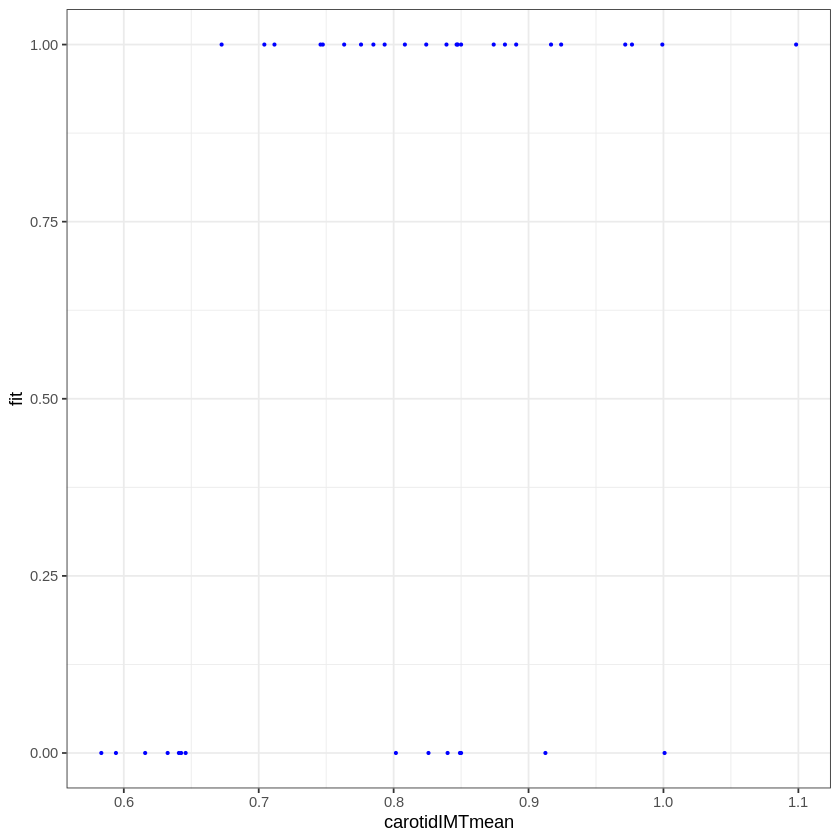

In [54]:
ggplot(copy_data_metadata, aes(x = carotidIMTmean, y = fit))+
  geom_point(data = data_metadata, aes(x = carotidIMTmean, y = Group), size = 0.5, color = 'blue') +
  theme_bw()

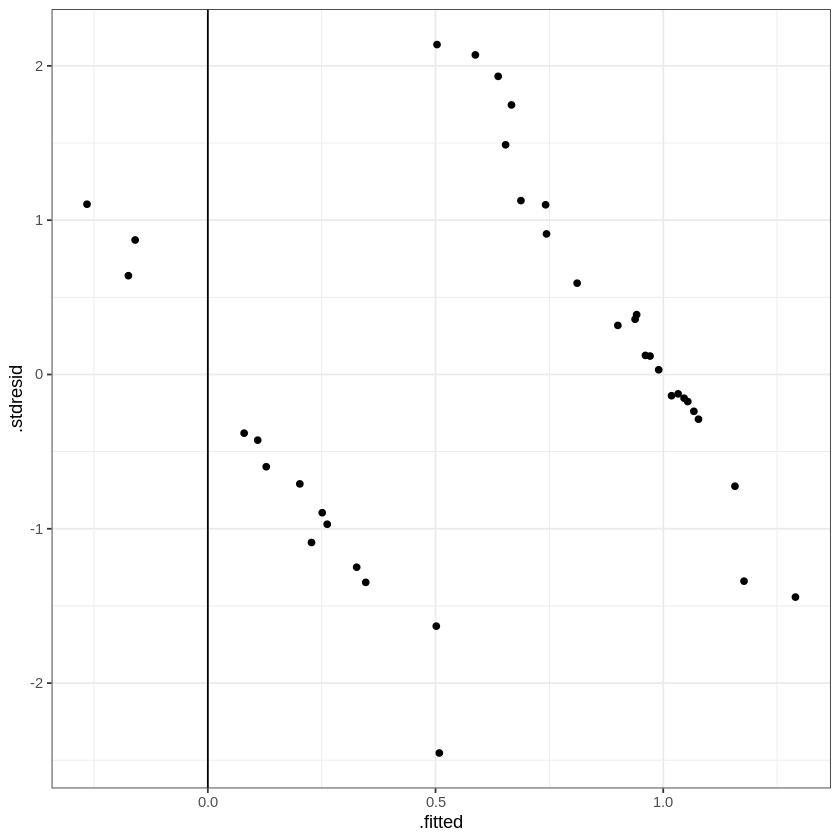

In [55]:
mod_classic_diag <- fortify(mod_classic)
ggplot(mod_classic_diag, aes(x = .fitted, y = .stdresid)) +
geom_point() +
geom_vline(xintercept = 0) +
theme_bw()

### Делим датасет на train и validation

In [47]:
fractionTraining   <- 0.85
fractionValidation <- 1 - fractionTraining

sampleSizeTraining   <- floor(fractionTraining   * nrow(data_metadata))
sampleSizeValidation <- floor(fractionValidation * nrow(data_metadata))

indicesTraining    <- sort(sample(seq_len(nrow(data_metadata)), size=sampleSizeTraining))
indicesNotTraining <- setdiff(seq_len(nrow(data_metadata)), indicesTraining)
indicesValidation  <- sort(sample(indicesNotTraining, size=sampleSizeValidation))

data_metadata_training   <- data_metadata[indicesTraining, ]
data_metadata_validation <- data_metadata[indicesValidation, ]

In [48]:
str(data_metadata_training)

'data.frame':	32 obs. of  31 variables:
 $ Group         : int  0 0 1 1 1 1 0 1 1 1 ...
 $ Age           : int  63 47 72 57 79 61 50 53 83 59 ...
 $ Plasmavolume  : num  6.5 5.5 5 5 6.2 6.5 6 5.5 6 5.5 ...
 $ Ht            : int  163 179 160 180 160 164 150 172 168 157 ...
 $ Wt            : num  84 111 58.8 71 64 67 79 88.2 59 70 ...
 $ BMI           : num  31.6 34.6 23 21.9 25 ...
 $ Sys           : int  125 125 130 135 110 124 142 120 134 120 ...
 $ Dia           : int  76 82 90 75 75 82 95 80 60 85 ...
 $ PR            : int  67 65 68 70 66 84 88 60 89 90 ...
 $ Choi          : int  215 271 266 194 286 280 319 202 177 266 ...
 $ Tgi           : int  219 147 132 101 121 114 307 117 154 105 ...
 $ HDLi          : num  65.3 52.1 51.9 76.8 61.9 61.1 67.1 47 108 64.9 ...
 $ LDLi          : num  106 190 188 97 200 ...
 $ Choi_exp      : num  5.58 7.04 6.91 5.04 7.43 ...
 $ Tgi_exp       : num  2.41 1.62 1.45 1.11 1.33 ...
 $ HDLi_exp      : num  1.7 1.35 1.35 1.99 1.61 ...
 $ LDLi_exp   

In [49]:
str(data_metadata_validation)

'data.frame':	5 obs. of  31 variables:
 $ Group         : int  1 1 1 0 0
 $ Age           : int  57 70 75 66 79
 $ Plasmavolume  : num  7 5.5 10 10 12
 $ Ht            : int  164 162 165 165 172
 $ Wt            : num  80 61 57 73 60
 $ BMI           : num  29.7 23.2 20.9 26.8 20.3
 $ Sys           : int  132 135 120 135 100
 $ Dia           : int  80 78 72 57 60
 $ PR            : int  92 72 66 72 65
 $ Choi          : int  206 267 196 254 240
 $ Tgi           : int  146 143 100 75 68
 $ HDLi          : num  38.6 57 68 99 87.3
 $ LDLi          : num  138 181 108 140 139
 $ Choi_exp      : num  5.35 6.94 5.09 6.6 6.23
 $ Tgi_exp       : num  1.604 1.571 1.099 0.824 0.747
 $ HDLi_exp      : num  1 1.48 1.77 2.57 2.27
 $ LDLi_exp      : num  3.58 4.7 2.81 3.64 3.61
 $ AI            : num  3.58 3.18 1.59 1.41 1.59
 $ rlatmin       : num  0.8 0.69 0.8 0.6 0.8
 $ rantmin       : num  0.8 0.62 0.8 0.6 0.8
 $ rposmin       : num  0.8 0.69 0.8 0.6 0.8
 $ llatmin       : num  0.8 0.8 0.8 0.5 0.

### Подбор логистической модели

#### Полная модель

In [61]:
mod <- glm(Group ~ ., family = binomial(link = 'logit'), data = data_metadata)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [63]:
# Anova(mod)

In [65]:
# drop1(mod, test = "Chi")

### Диагностика модели

#### Проверка на линейность


In [69]:
# mod_classic_diag <- data.frame(.fitted = fitted(data_metadata, type = 'response'),
#                         .resid_p = resid(data_metadata, type = 'pearson'))

# ggplot(mod_classic_diag, aes(y = .resid_p, x = .fitted)) +
#   geom_point() +
#   theme_bw() +
#   geom_hline(yintercept = 0) +
#   geom_smooth(method = 'loess')